In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../')
%run setup.py install
os.chdir(owd)

In [2]:
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
## population and age classes
M=16  ## number of age classes

my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

In [5]:
C=CH+CW+CS+CO
#C=CH+CW+CO

# epidemic parameters
alpha = 0.              # asymptomatic fraction
beta  = 0.0155          # contact rate parameter
gamma = 1./7            # recovery rate 
fsa   = 1               # suppresion of contact by symptomatics

Tf=21*2-1; 
CTS = np.zeros((2*Tf, M*M))

for i in range(2*Tf):
    CTS[i, :] = C.reshape(M*M)
C  = CTS[0,:].reshape(M,M)  
    
    
# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gamma*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gamma*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gamma)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gamma)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (2.1055544598981144+0j)


In [6]:
# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

# start simulation
model = pyross.models.SIR(S_0, Ia_0, Is_0, alpha, beta, gamma, fsa, M, Ni, Tf)
Nf=1000;  filename='this.mat'
model.simulate(CTS, Nf, filename)

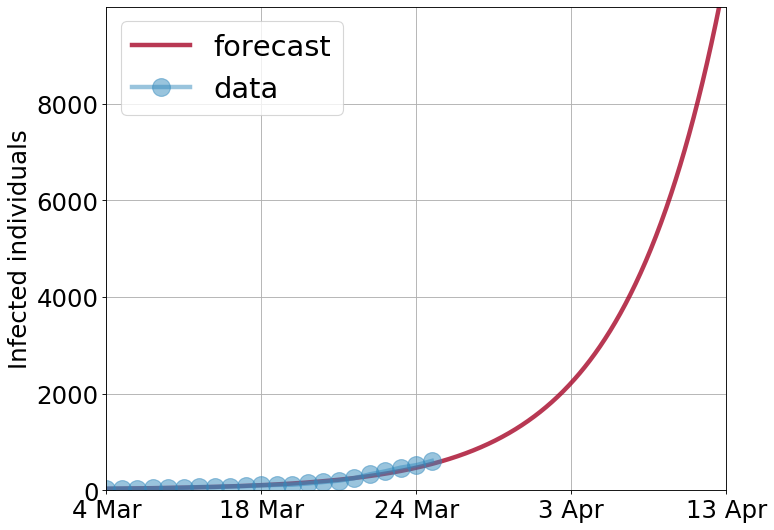

In [7]:
from scipy.io import loadmat

data=loadmat(filename); t = data['t'][0]; IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, Tf, 10), ('4 Mar', '18 Mar', '24 Mar', '3 Apr', '13 Apr', '23 Apr'));

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)

In [8]:
C0=CH+CW+CS+CO
#C=CH+CW+CO

Tf=200; 
CTS = np.zeros((2*Tf, M*M))

for i in range(2*Tf):
    CTS[i, :] = C0.reshape(M*M)
C  = CTS[0,:].reshape(M,M)  
    
# epidemic parameters
alpha = 0.              # asymptomatic fraction
beta  = 0.0155          # contact rate parameter
gamma = 1./7            # recovery rate 
fsa   = 1               # factor of contact by symptomatics

# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]
L[0:M, 0:M]     =    alpha*beta/gamma*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gamma*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gamma)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gamma)*L0

r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

# start simulation
model = pyross.models.SIR(S_0, Ia_0, Is_0, alpha, beta, gamma, fsa, M, Ni, Tf)
Nf=2000; filename='this.mat'
model.simulate(CTS, Nf, filename)

The basic reproductive ratio for these parameters is (2.1055544598981144+0j)


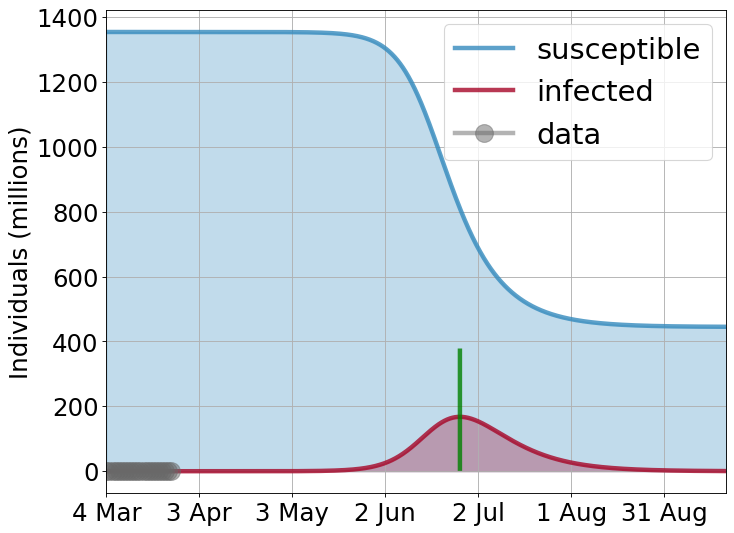

In [9]:
from scipy.io import loadmat
data=loadmat(filename)
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))


for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i]
t = data['t'][0]

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, SC*10**(-6), '-', lw=4, color='#348ABD', label='susceptible', alpha=0.8,)
plt.fill_between(t, 0, SC*10**(-6), color="#348ABD", alpha=0.3)

plt.plot(t, IC*10**(-6), '-', lw=4, color='#A60628', label='infected', alpha=0.8)
plt.fill_between(t, 0, IC*10**(-6), color="#A60628", alpha=0.3)

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]
plt.plot(cases*10**(-6), 'ro-', lw=4, color='dimgrey', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Individuals (millions)')
plt.plot(t*0+t[np.argsort(IC)[-1]], -170+.4*SC*10**(-6), lw=4, color='g', alpha=0.8)
plt.xticks(np.arange(0, 200, 30), ('4 Mar', '3 Apr', '3 May', '2 Jun', '2 Jul', '1 Aug', '31 Aug'));
#plt.savefig('/Users/rsingh/Desktop/2b.png', format='png', dpi=212)

In [17]:
IC[np.argsort(IC)[-1]]

167682499.37145126

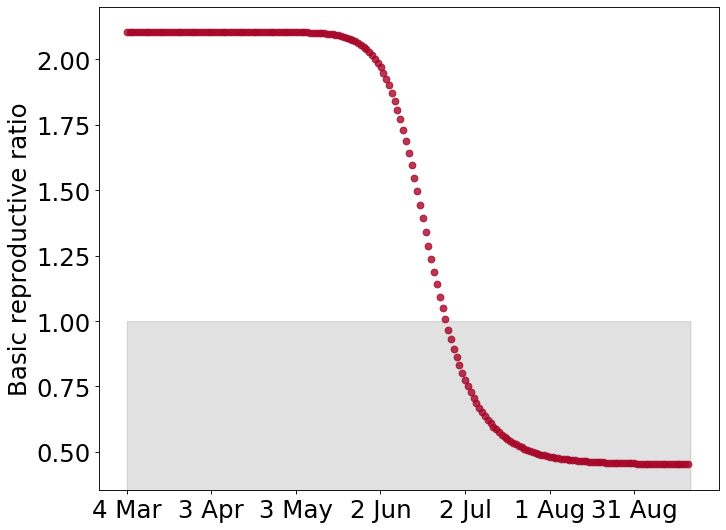

In [10]:
# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))
xind=[np.argsort(IC)[-1]]
rr = np.zeros((Tf))

for tt in range(Tf):
    C  = CTS[tt,:].reshape(M,M)  
    Si = np.array((data['X'][tt*10,0:M])).flatten()
    for i in range(M):
        for j in range(M):
            L0[i,j]=C[i,j]*Si[i]/Ni[j]
    L[0:M, 0:M]     =    alpha*beta/gamma*L0
    L[0:M, M:2*M]   = fsa*alpha*beta/gamma*L0
    L[M:2*M, 0:M]   =    ((1-alpha)*beta/gamma)*L0
    L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gamma)*L0

    rr[tt] = np.real(np.max(np.linalg.eigvals(L)))
    
    
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t[::10], rr, 'o', lw=4, color='#A60628', label='suscetible', alpha=0.8,)
plt.fill_between(t, 0, t*0+1, color="dimgrey", alpha=0.2); plt.ylabel('Basic reproductive ratio')
plt.ylim(np.min(rr)-.1, 2.2)
plt.xticks(np.arange(0, 200, 30), ('4 Mar', '3 Apr', '3 May', '2 Jun', '2 Jul', '1 Aug', '31 Aug'));
#plt.savefig('/Users/rsingh/Desktop/test.png', format='png', dpi=212) 

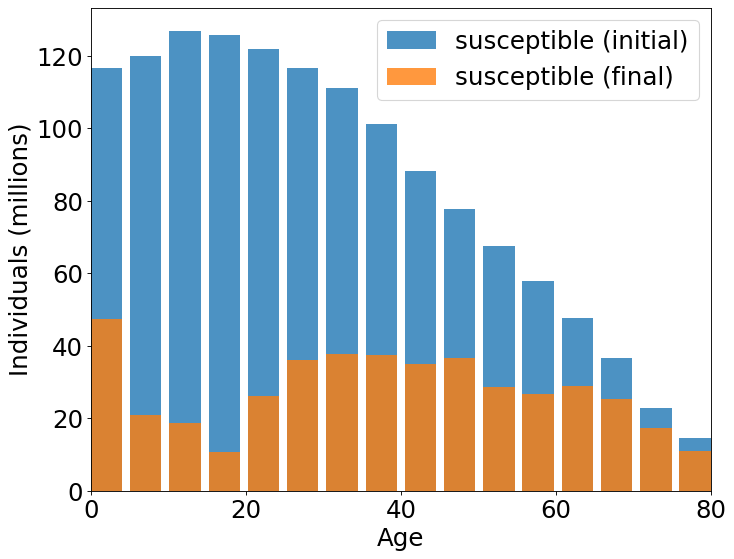

In [11]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.bar(np.arange(16),data['X'][0,0:M]*10**(-6),   label='susceptible (initial)', alpha=0.8)
plt.bar(np.arange(16),data['X'][-1,0:M]*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Individuals (millions)'); plt.xlabel('Age')
plt.legend(fontsize=22); plt.axis('tight')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('/Users/rsingh/Desktop/3a.png', format='png', dpi=212)

In [12]:
MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  
## Fatality Rate by AGE per 100 cases

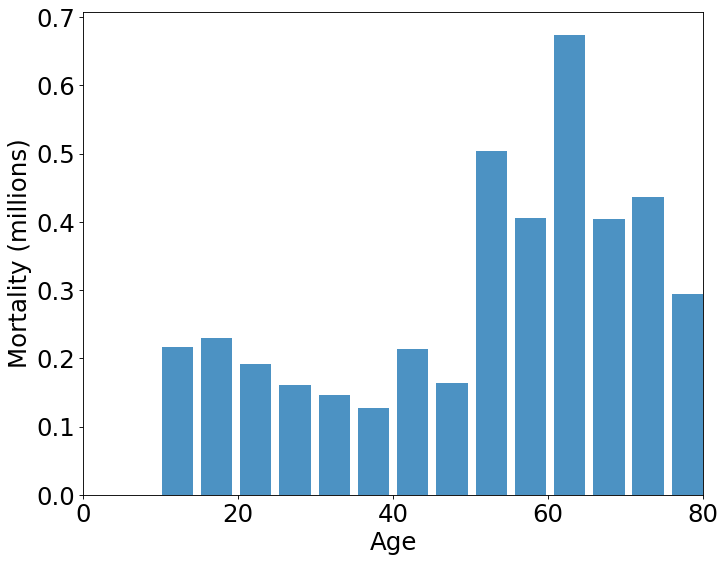

In [13]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
plt.bar(np.arange(16),m1*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.axis('tight'); plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Mortality (millions)'); plt.xlabel('Age')

plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('/Users/rsingh/Desktop/3b.png', format='png', dpi=212)

In [14]:
m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
np.sum(m1)

4169151.9037979427